## Packages and Modules

In [1]:
# For data manipulation
import pandas as pd
import numpy as np
import re

# For data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pprint import pprint
import wordcloud

# For topic modeling
import spacy
from spacy.lang.en import English
parser = English()
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
try:
  import pyLDAvis
except:
  !pip install pyLDAvis
  import pyLDAvis
import pyLDAvis.gensim_models
import pickle

# Connect to Google drive
from google.colab import drive
drive.mount('/content/gdrive')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


## Functions

In [2]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('TWITTER_HANDLE')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

def subset_df(df, term):
  temp_df = df.copy()
  index_list = []
  for i in range(len(temp_df)):
    temp_list = temp_df['tweet'][i]
    for j in temp_list:
      if term in j:
        index_list.append(i)
      else:
        continue
  temp_df = temp_df.iloc[index_list]
  temp_df = temp_df.reset_index(drop=True)
  return temp_df

def lda_model_grid(df, col):
  df_text = []
  for i in range(10):
      tokens = df[col][i]
      df_text.append(tok for tok in tokens)
      df_text.append(tokens)

  df_dict = corpora.Dictionary(df_text)
  df_corpus = [df_dict.doc2bow(text) for text in df[col]]

  # Create model and save
  topics = []
  complexity = []
  coherence = []
  for i in range(2, 10):
    print(f"Checking model with {i} topics.")
    # Build model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=df_corpus, 
                                                  id2word=df_dict, 
                                                  num_topics=i, 
                                                  random_state=100,
                                                  update_every=1, 
                                                  chunksize=1000, 
                                                  passes=10, 
                                                  alpha='auto', 
                                                  per_word_topics=True)
    # Compute complexity and coherence score
    cmplx = lda_model.log_perplexity(df_corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                        texts=df[col], 
                                        dictionary=df_dict, 
                                        coherence='c_v')
    coh = coherence_model_lda.get_coherence()
    topics.append(i)
    complexity.append(cmplx)
    coherence.append(coh)

  # Save as a df
  df_df = pd.DataFrame({'topics': topics, 
                        'complexity':complexity, 
                        'coherence':coherence})
  return df_df

def line_plot(df, col, save_name):
  plt.figure(figsize=(10, 7))
  sns.lineplot(x='topics', y=col, marker='o', 
                size=15, color='k', data=df, 
               legend=False)
  plt.ylabel(col, fontsize=24, labelpad=20)
  plt.yticks(fontsize=18)
  plt.xlabel("Topics", fontsize=24, labelpad=20)
  plt.xticks(fontsize=18)
  plt.savefig(f'{save_name}.png', bbox_inches='tight')
  plt.show()

def lda_one_topic(df, col, topics, savename):
  df_text = []
  for i in range(10):
      tokens = df[col][i]
      df_text.append(tok for tok in tokens)
      df_text.append(tokens)

  df_dict = corpora.Dictionary(df_text)
  df_corpus = [df_dict.doc2bow(text) for text in df[col]]

  # Build model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=df_corpus, 
                                              id2word=df_dict, 
                                              num_topics=topics, 
                                              random_state=100,
                                              update_every=1, 
                                              chunksize=1000, 
                                              passes=10, 
                                              alpha='auto', 
                                              per_word_topics=True)
  lda_model.save(f'{savename}.gensim')
  all_topics = lda_model.print_topics(num_words=50)
  all_topics = pd.DataFrame(all_topics)
  all_topics.to_csv(f'topic_words_{savename}.csv')
  pyLDAvis.enable_notebook()
  lda_display = pyLDAvis.gensim_models.prepare(lda_model, 
                                              df_corpus, 
                                              df_dict, 
                                              sort_topics=False)
  pyLDAvis.display(lda_display)
  pyLDAvis.save_html(lda_display, f'lda_vis_{savename}.html')
  return all_topics

## Read in data

In [3]:
# Import data
# raw_data = pd.read_csv('../data/03_primary/all_data.csv')
raw_data = pd.read_csv('/content/gdrive/MyDrive/Twitter-Higher-Ed/03_primary/all_data.csv')
data = raw_data.copy()
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,outlinks,tcooutlinks,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,time,vader_pos,vader_neu,vader_neg,vader_com,text_blob_polarity,text_blob_subjectivity,year
0,0,snscrape.modules.twitter.Tweet,https://twitter.com/eraser/status/125597019446...,2020-04-30 21:20:03+00:00,eteacher: providing personalized assistance to...,eTeacher: Providing personalized assistance to...,1.255970e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,0.0,0.0,1.255970e+18,it,"<a href=""https://www.hootsuite.com"" rel=""nofol...",https://www.hootsuite.com,Hootsuite Inc.,['http://e-learning-teleformacion.blogspot.com...,['https://t.co/bepADMLveA'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['elearning', 'mlearning', 'eteacher', 'educat...",NaN,pre-COVID,0.000,1.000,0.000,0.0000,0.000000,0.000000,2020
1,1,snscrape.modules.twitter.Tweet,https://twitter.com/SenthilkumarSrr/status/125...,2020-04-30 20:55:34+00:00,civil engineering department of sona college o...,Civil Engineering Department of Sona College o...,1.255964e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,1.0,0.0,1.255964e+18,en,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.Photo', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['lockdown', 'digitalLearning', 'SonaCollegeOf...",NaN,pre-COVID,0.093,0.907,0.000,0.5106,-0.025000,0.450000,2020
2,2,snscrape.modules.twitter.Tweet,https://twitter.com/thewrightside9/status/1255...,2020-04-30 19:11:55+00:00,i just hosted a google meet and we ended up li...,I just hosted a google meet and we ended up li...,1.255938e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,3.0,0.0,1.255938e+18,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['teacher', 'digitallearning', 'digitalmentalh...",NaN,pre-COVID,0.138,0.862,0.000,0.8519,0.800000,0.800000,2020
3,3,snscrape.modules.twitter.Tweet,https://twitter.com/mrsdzscientists/status/125...,2020-04-30 18:08:15+00:00,super cool special effects during our live bro...,Super Cool Special Effects during our live Bro...,1.255922e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,3.0,0.0,1.255922e+18,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.Photo', '...",NaN,NaN,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,"['space', 'NASA', 'DigitalLearning', 'together...",NaN,pre-COVID,0.203,0.753,0.043,0.7906,0.294210,0.597024,2020
4,4,snscrape.modules.twitter.Tweet,https://twitter.com/mrsdzscientists/status/125...,2020-04-30 18:00:47+00:00,talented &amp; reporting live 🎤during digital ...,Talented &amp; Reporting live 🎤during Digital ...,1.255920e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0.0,0.0,3.0,0.0,1.255920e+18,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.Photo', '...",NaN,NaN,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,"['space', 'NASA', 'DigitalLearning', 'together...",NaN,pre-COVID,0.089,0.860,0.051,0.3400,0.278788,0.466667,2020


## Text Cleaning

In [6]:
# Clean up data for topic modeling
import random
import warnings
warnings.simplefilter('ignore')
text_data = []
for i in range(len(data)):
    tokens = prepare_text_for_lda(data['content'][i])
    text_data.append(tokens)

In [7]:
# Create dataframe with the cols we need
df = pd.DataFrame({'tweet':text_data, 
                   'sentiment':data['vader_com'], 
                   'year':data['year']})
df.head()

,tweet,sentiment,year
0,"[eteacher, provide, personalize, assistance, l...",0.0000,2020
1,"[civil, engineering, department, college, tech...",0.5106,2020
2,"[host, google, end, listening, freeze, sound, ...",0.8519,2020
3,"[super, special, effects, broadcast, TWITTER_H...",0.7906,2020
4,"[talented, reporting, digital, learning, TWITT...",0.3400,2020


## Wordclouds

In [8]:
# Make sure the cols are numeric
df['sentiment'] = df['sentiment'].astype(float)
df['year'] = df['year'].astype(int)

In [9]:
# Separate positive vs. negative, various tech platforms
ggl = subset_df(df=df, term="google")
msft = subset_df(df=df, term="microsoft")
cnvs = subset_df(df=df, term="canva")
blbd = subset_df(df=df, term="blackboard")
zm = subset_df(df=df, term="zoom")

In [10]:
# Import wordcloud library
from wordcloud import WordCloud
trouble_list = ['amp', 'gt', '30pm', '30am', '00am', '00pm', 'lt', '15pm', 
                'org', 'edu']

# Join Google together
list_l_str_ggl = list(set([a for b in ggl['tweet'].tolist() for a in b]))
l_str_ggl = ", ".join(list_l_str_ggl)
for i in trouble_list:
  try:
    l_str_ggl = l_str_ggl.replace(i, "")
  except:
    continue

# Join Microsoft together
list_l_str_msft = list(set([a for b in msft['tweet'].tolist() for a in b]))
l_str_msft = ", ".join(list_l_str_msft)
for i in trouble_list:
  try:
    l_str_msft = l_str_msft.replace(i, "")
  except:
    continue

# Join Canvas together
list_l_str_cnvs = list(set([a for b in cnvs['tweet'].tolist() for a in b]))
l_str_cnvs = ", ".join(list_l_str_cnvs)
for i in trouble_list:
  try:
    l_str_cnvs = l_str_cnvs.replace(i, "")
  except:
    continue

# Join Blackboard together
list_l_str_blbd = list(set([a for b in blbd['tweet'].tolist() for a in b]))
l_str_blbd = ", ".join(list_l_str_blbd)
for i in trouble_list:
  try:
    l_str_blbd = l_str_blbd.replace(i, "")
  except:
    continue

# Join Zoom together
list_l_str_zm = list(set([a for b in zm['tweet'].tolist() for a in b]))
l_str_zm = ", ".join(list_l_str_zm)
for i in trouble_list:
  try:
    l_str_zm = l_str_zm.replace(i, "")
  except:
    continue

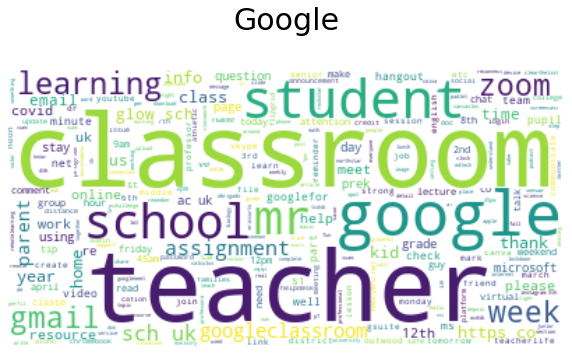

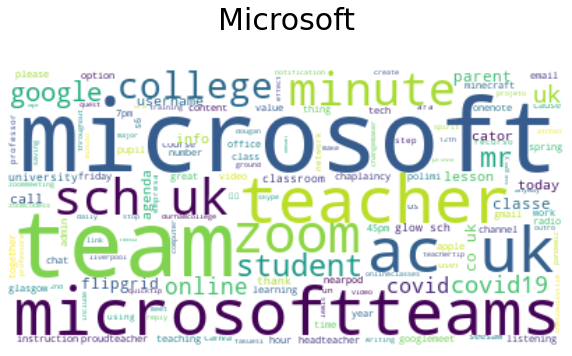

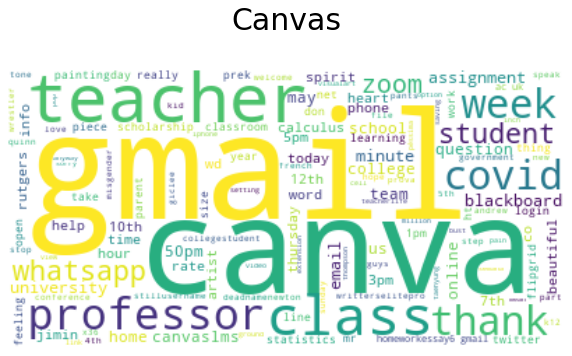

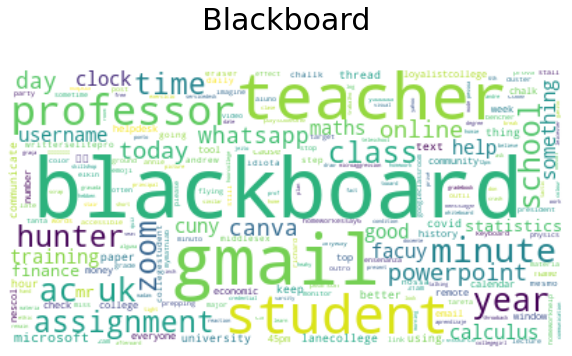

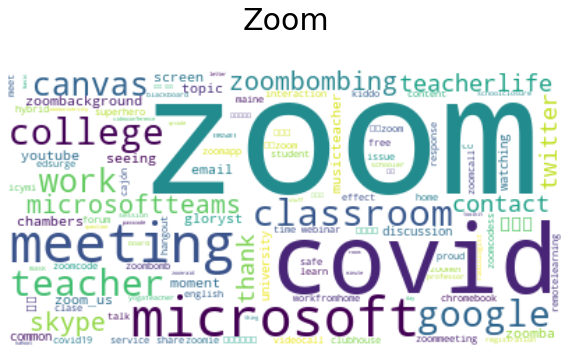

In [11]:
# Create wordcloud objects
title_list = ['Google', 'Microsoft', 
              'Canvas', 'Blackboard', 'Zoom']
position = 0 
for item in [l_str_ggl, l_str_msft, l_str_cnvs, l_str_blbd, l_str_zm]:
    plt.figure(figsize=(10, 7))
    wordcloud = WordCloud(background_color='white', max_words=2000, 
                      contour_width=3, contour_color='steelblue', 
                      collocations=True)
    item 
    wordcloud.generate(item)
    wordcloud.to_image()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_list[position], fontsize=30, pad=40)
    plt.savefig(f'word_cloud_{title_list[position]}.png')
    plt.show()
    position+=1
    print("\n\n")

## LDA with Gensim

Checking model with 2 topics.
Checking model with 3 topics.
Checking model with 4 topics.
Checking model with 5 topics.
Checking model with 6 topics.
Checking model with 7 topics.
Checking model with 8 topics.
Checking model with 9 topics.


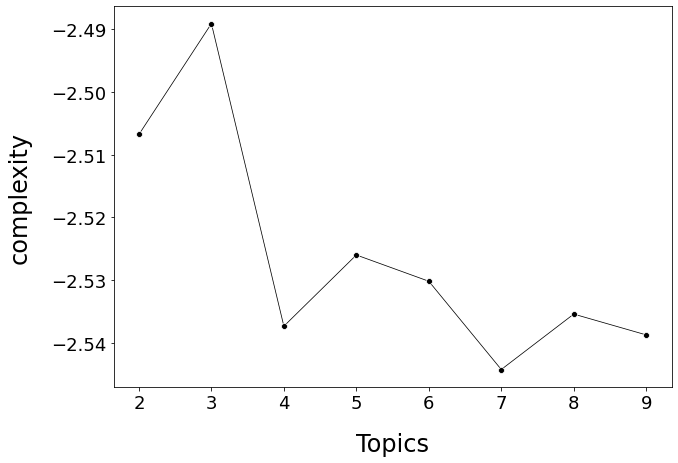

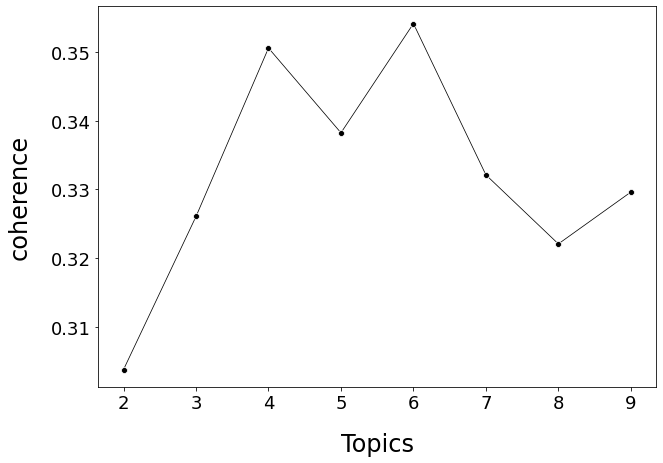

In [12]:
# LDA for Google
import warnings
warnings.filterwarnings("ignore")
ggl_lda = lda_model_grid(df=ggl, col='tweet')
line_plot(df=ggl_lda, col='complexity', save_name='complexity_ggl')
line_plot(df=ggl_lda, col='coherence', save_name='coherence_ggl')

Checking model with 2 topics.
Checking model with 3 topics.
Checking model with 4 topics.
Checking model with 5 topics.
Checking model with 6 topics.
Checking model with 7 topics.
Checking model with 8 topics.
Checking model with 9 topics.


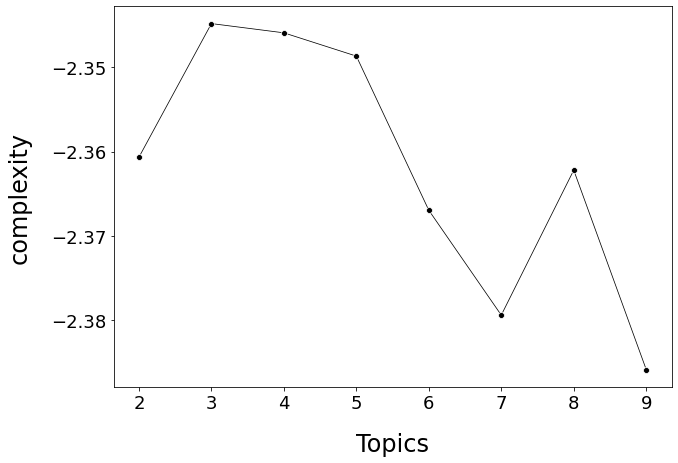

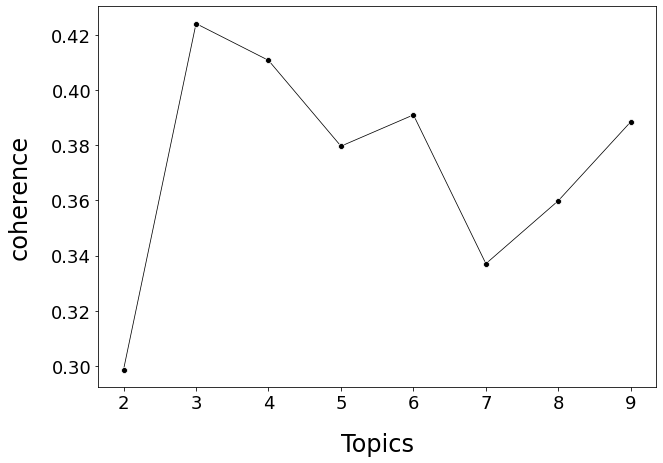

In [13]:
# LDA for Microsoft
msft_lda = lda_model_grid(df=msft, col='tweet')
line_plot(df=msft_lda, col='complexity', save_name='complexity_msft')
line_plot(df=msft_lda, col='coherence', save_name='coherence_msft')

Checking model with 2 topics.
Checking model with 3 topics.
Checking model with 4 topics.
Checking model with 5 topics.
Checking model with 6 topics.
Checking model with 7 topics.
Checking model with 8 topics.
Checking model with 9 topics.


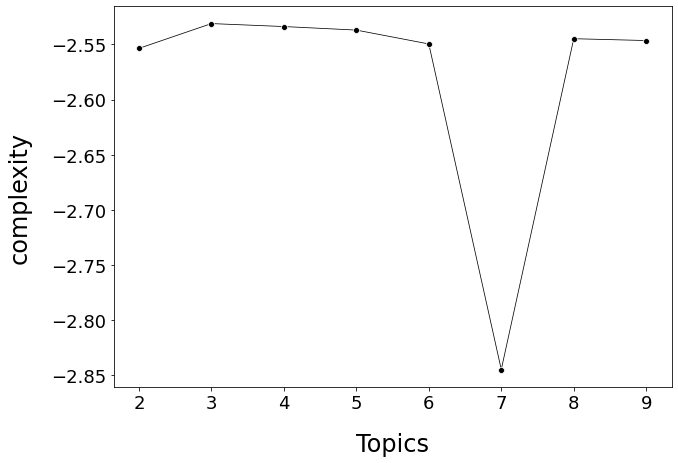

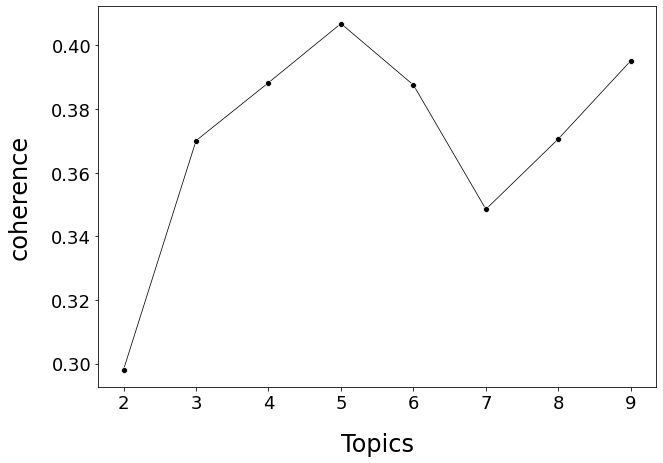

In [14]:
# LDA for Canvas
cnvs_lda = lda_model_grid(df=cnvs, col='tweet')
line_plot(df=cnvs_lda, col='complexity', save_name='complexity_cnvs')
line_plot(df=cnvs_lda, col='coherence', save_name='coherence_cnvs')

Checking model with 2 topics.
Checking model with 3 topics.
Checking model with 4 topics.
Checking model with 5 topics.
Checking model with 6 topics.
Checking model with 7 topics.
Checking model with 8 topics.
Checking model with 9 topics.


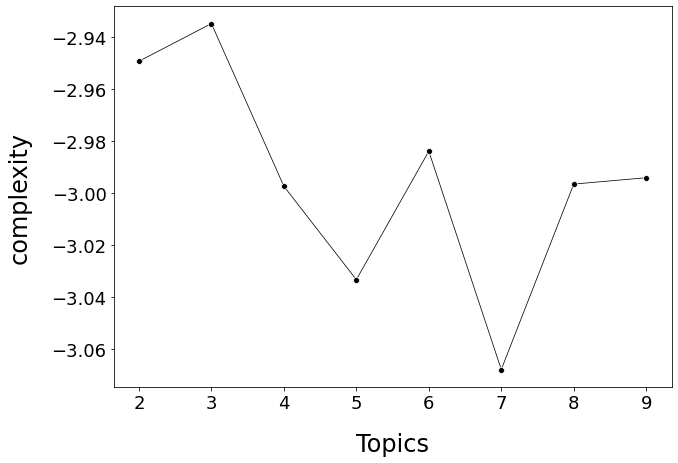

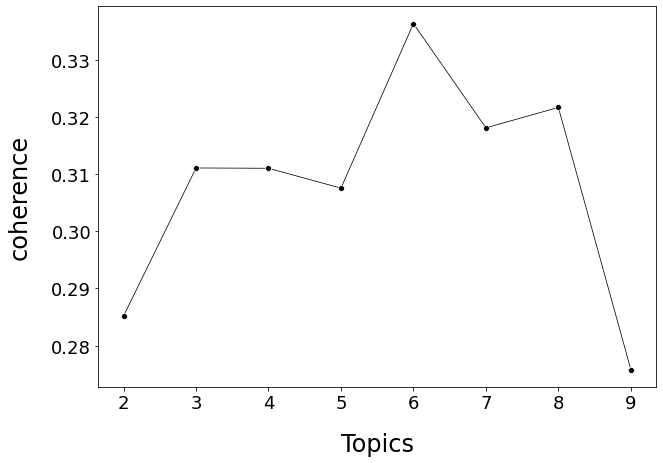

In [15]:
# LDA for Blackboard
blbd_lda = lda_model_grid(df=blbd, col='tweet')
line_plot(df=blbd_lda, col='complexity', save_name='complexity_blbd')
line_plot(df=blbd_lda, col='coherence', save_name='coherence_blbd')

Checking model with 2 topics.
Checking model with 3 topics.
Checking model with 4 topics.
Checking model with 5 topics.
Checking model with 6 topics.
Checking model with 7 topics.
Checking model with 8 topics.
Checking model with 9 topics.


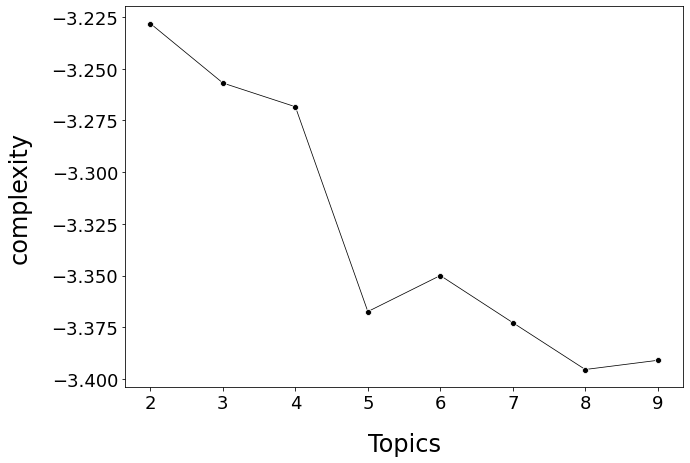

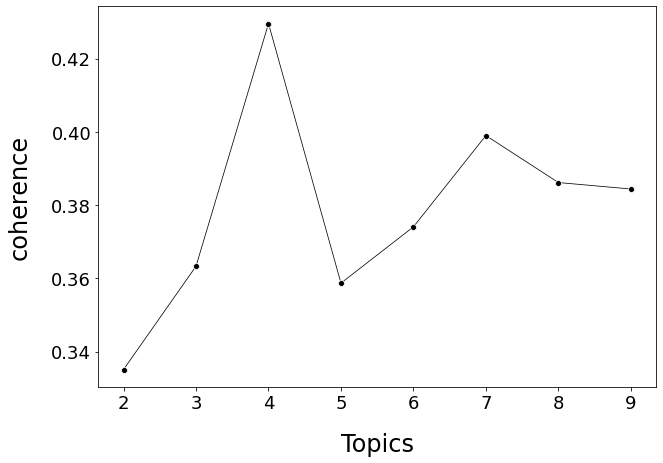

In [16]:
# LDA for Zoom
zm_lda = lda_model_grid(df=zm, col='tweet')
line_plot(df=zm_lda, col='complexity', save_name='complexity_zm')
line_plot(df=zm_lda, col='coherence', save_name='coherence_zm')

## Build topic models using the least complex number of topics. 

In [17]:
# Google = 6 topics
ggl_topics = lda_one_topic(df=ggl, col='tweet', topics=6, savename='ggl_tweets')

In [18]:
# Microsoft = 9 topics
msft_topics = lda_one_topic(df=msft, col='tweet', topics=9, savename='msft_tweets')

In [19]:
# Canvas tweets = 5 topics
cnvs_topics = lda_one_topic(df=cnvs, col='tweet', topics=5, savename='cnvs_tweets')

In [20]:
# Blackboard = 7 topics
blbd_topics = lda_one_topic(df=blbd, col='tweet', topics=7, savename='blbd_tweets')

In [21]:
# Zoom = 7 topics
zm_topics = lda_one_topic(df=zm, col='tweet', topics=7, savename='zm_tweets')